In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline
import matplotlib.colors as colors
import matplotlib as mpl



# Functions to plot the individual or ensemble llr + calculate the confidence limits

In [3]:
def find_confidence_limits(x_interp, rescaled_log_r_interp, threshold):
    # Find the x-values where the interpolated LLR crosses the confidence level threshold
    crossings = np.where(np.diff(np.sign(rescaled_log_r_interp - threshold)))[0]
    if len(crossings) >= 2:  # Need at least two crossings (one on either side of the best-fit point)
        lower_limit = x_interp[crossings[0]]
        upper_limit = x_interp[crossings[1]]

        # Find the minimum (best-fit point) of the interpolated LLR
        min_index = np.argmin(rescaled_log_r_interp)
        central_value = x_interp[min_index]

        # Print the confidence limits and central value in the desired format
        print(f"Confidence limits at threshold {threshold}: [{lower_limit:.3f}, {upper_limit:.3f}]")
       


def plot_llr_individual(config):

    plt.figure(figsize=(7,6))

    load_dir = f"{config['main_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/{config['sample_name']}/range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"
    fig_name = f"llr_fit_individual_{config['sample_name']}_range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"

    os.makedirs(f"{config['plot_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/",exist_ok=True)
    save_dir = f"{config['plot_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/"
    
    colors = ['#332288', '#117733', '#CC6677', '#882255','44AA99']

    # Define interpolation points
    num_points = 1001
    x_interp = np.linspace(-1.2, 1.2, num_points)  # Adjusted range and density



    for i in range(5):
    
      estimator_number = i + 1
      dir =  load_dir + f"/estimator_{i}_data.npz"

      data = np.load(dir)

      parameter_grid = data['parameter_grid']
      llr_kin = data['llr_kin']
      llr_rate = data['llr_rate']
      index_best_point = data['index_best_point']

      rescaled_log_r = llr_kin+llr_rate
      rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    

      if config['limits']['method'] == 'sally':
         title = r'$\bf{SALLY}$' 

      if config['limits']['method'] == 'alices':
         title = r'$\bf{ALICES}$' + r'$\ (\alpha = 5, n_{\theta_0} = 1000)$'

      if config['limits']['method'] == 'alice':
         title = r'$\bf{ALICE}$' + r'$\ (\alpha = 0, n_{\theta_0} = 1000)$'

      # Perform quadratic spline interpolation
      spline = UnivariateSpline(parameter_grid, rescaled_log_r, k=2, s=0)
      rescaled_log_r_interp = spline(x_interp)

      

      lw=1.5
      plt.plot(x_interp, rescaled_log_r_interp ,linewidth=lw, label=f"Estimator {estimator_number}",color=colors[i])    
      
      # Add horizontal lines and labels for CL
      plt.axhline(y=1.0, color='gray', linestyle='-.', linewidth=1.2)
      plt.axhline(y=3.84, color='gray', linestyle='--', linewidth=1.2)

      # Adding text labels directly on the lines
      plt.text(-0.095, 1.0, '68% CL', color='gray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
      plt.text(-0.095, 3.84, '95% CL', color='gray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)

    plt.xlabel(r"$c_{H\tilde{W}}$", size=14)
    plt.ylabel(r"$q(\theta)$", size=14) 
    plt.ylim(-0.02,10)
    plt.xlim(-0.1,0.1)
    luminosity_info =  r"$u \bar{d} \rightarrow W^+ H \rightarrow \mu^+ \nu_{\mu} b \bar{b}$, KO" + "\n" + r"$\mathcal{L} = 300\, \mathrm{fb}^{-1}$"  
    
    text = title + "\n" + luminosity_info
    plt.text(-0.003, 8, text,
         fontsize=12,   # Center the text horizontally
         bbox=dict(facecolor='white', edgecolor='none', alpha=0.5),horizontalalignment='center')
    plt.legend(title_fontsize=12, frameon=False,fontsize=11        ,handlelength=2.5,                         # Adjust length of legend lines
        labelspacing=0.4,facecolor='white',loc = "upper center",bbox_to_anchor=(0.47, 0.8))
    
    plt.savefig(f"{save_dir}/{fig_name}.pdf")
    

def calculate_std(config):
    
    load_dir = f"{config['main_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/{config['sample_name']}/range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"
    

    predictions = []

    for i in range(5):
    
      estimator_number = i + 1
      dir =  load_dir + f"/estimator_{i}_data.npz"

      data = np.load(dir)

      parameter_grid = data['parameter_grid']
      llr_kin = data['llr_kin']
      llr_rate = data['llr_rate']
      index_best_point = data['index_best_point']

      rescaled_log_r = llr_kin+llr_rate
      rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    
      predictions.append(rescaled_log_r)

    std_deviation = np.std(predictions, axis=0)
    
    return std_deviation

def plot_llr_ensemble(config):
    
    plt.figure(figsize=(7,6))
    
    load_dir = f"{config['main_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/{config['sample_name']}/range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"

    fig_name = f"llr_fit_ensemble_{config['sample_name']}_range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"

    os.makedirs(f"{config['plot_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/",exist_ok=True)
    save_dir = f"{config['plot_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/"
    
    data = np.load(f"{load_dir}/ensemble_data.npz")

    parameter_grid = data['parameter_grid']
    llr_kin = data['llr_kin']
    llr_rate = data['llr_rate']
    index_best_point = data['index_best_point']

    # Define interpolation points
    num_points = 1001
    x_interp = np.linspace(-1.2, 1.2, num_points)  # Adjusted range and density


    if config['limits']['method'] == 'sally':
      title = r'$\bf{SALLY}$' 
      color = 'mediumvioletred'

    if config['limits']['method'] == 'alices':
      title = r'$\bf{ALICES}$' + r'$\ (\alpha = 5, n_{\theta_0} = 10000)$'
      color = 'mediumblue'

    if config['limits']['method'] == 'alice':
      title = title = r'$\bf{ALICE}$' + r'$\ (\alpha = 0, n_{\theta_0} = 1000)$'
      color = 'darkgreen'
        


    plt.figure(figsize=(7, 6))

    rescaled_log_r = llr_kin+llr_rate
    rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    

    std = calculate_std(config)
    std = np.squeeze(std)
    parameter_grid = np.squeeze(parameter_grid)
    
    # Perform quadratic spline interpolation
    spline = UnivariateSpline(parameter_grid, rescaled_log_r, k=2, s=0)
    rescaled_log_r_interp = spline(x_interp)
    
    # Perform quadratic spline interpolation for the standard deviation
    spline_std = UnivariateSpline(parameter_grid, std, k=2, s=0)
    std_interp = spline_std(x_interp)
    
    min_index = np.argmin(rescaled_log_r_interp)
    central_value = x_interp[min_index]
    std_at_min = std_interp[min_index]  # Standard deviation at the minimum
    
    # Print the results
    print(f"Central value (minimum of the LLR): {central_value:.3f}")
    print(f"Standard deviation at the central value: {std_at_min:.3f}")
    

    lw = 1.5
    # Fill the region between the interpolated log-likelihood ± interpolated standard deviation
    plt.fill_between(x_interp, rescaled_log_r_interp - std_interp, rescaled_log_r_interp + std_interp, color=color, alpha=0.1)
    

    plt.plot(x_interp, rescaled_log_r_interp ,linewidth=lw, color=color)    
    
    # # Add horizontal lines and labels for CL
    # plt.axhline(y=1.0, color='dimgray', linestyle='-.', linewidth=1.2)
    # plt.axhline(y=3.84, color='dimgray', linestyle='--', linewidth=1.2)

    # Adding text labels directly on the lines
    # plt.text(-0.095, 1.0, '68% CL', color='dimgray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
    # plt.text(-0.095, 3.84, '95% CL', color='dimgray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
    

    plt.xlabel(r"$c_{H\tilde{W}}$", size=14)
    plt.ylabel(r"$q(\theta)$", size=14) 
    plt.ylim(-0.02,500)
    plt.xlim(-1.2,1.2)
    luminosity_info =  r"$u \bar{d} \rightarrow W^+ H \rightarrow \mu^+ \nu_{\mu} b \bar{b}$, KO" + "\n" + r"$\mathcal{L} = 300\, \mathrm{fb}^{-1}$"  
    
    #text = title + "\n" + luminosity_info
    # plt.text(0.001, 8, text,
    #      fontsize=12,   # Center the text horizontally
    #      bbox=dict(facecolor='white', edgecolor='none', alpha=0.5),horizontalalignment='center')
    
    #plt.savefig(f"{save_dir}/{fig_name}.pdf", dpi=600,bbox_inches='tight')
    
     # Find confidence limits
    find_confidence_limits(x_interp, rescaled_log_r_interp, 1.0)
    find_confidence_limits(x_interp, rescaled_log_r_interp, 3.84)


Central value (minimum of the LLR): -0.007
Standard deviation at the central value: 0.098
Confidence limits at threshold 1.0: [-0.024, 0.005]
Confidence limits at threshold 3.84: [-0.036, 0.019]


<Figure size 504x432 with 0 Axes>

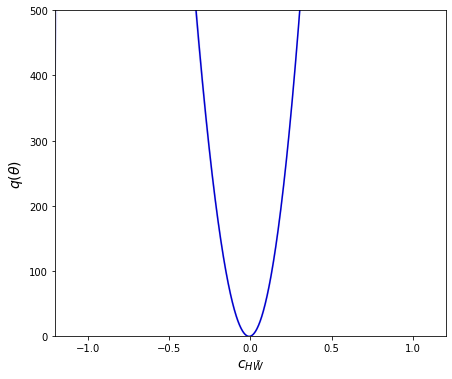

In [4]:
config = {
    'main_dir': '/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes',
    'sample_name': 'wh_signalWithBSM_CP_even',
    'plot_dir': '/lstore/titan/martafsilva/master_thesis/thesis_plots',
    'limits': {
        'mode': 'ml',
        'observables': 'kinematic_only',
        'prior': 'alices_gaussian_prior_0_03_10000_thetas_5000000_samples_CP_even',
        'model': 'alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128',
        'method': 'alices',
        'lumi': 300,
        'grid_ranges': [-1.0,1.0],
        'grid_resolutions': 303
    }
}


plot_llr_ensemble(config)



Central value (minimum of the LLR): 0.007
Standard deviation at the central value: 0.004
Confidence limits at threshold 1.0: [-0.096, 0.110]
Confidence limits at threshold 3.84: [-0.190, 0.204]


<Figure size 504x432 with 0 Axes>

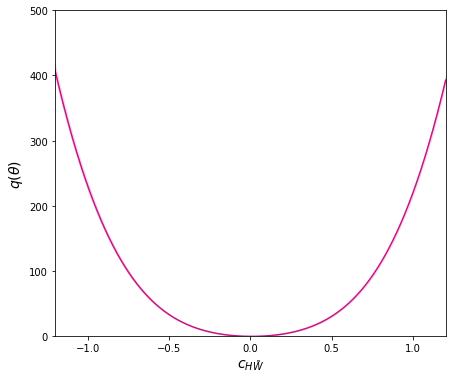

In [5]:
config = {
    'main_dir': '/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes',
    'sample_name': 'wh_signalWithBSMAndBackgrounds',
    'plot_dir': '/lstore/titan/martafsilva/master_thesis/thesis_plots',
    'limits': {
        'mode': 'ml',
        'observables': 'all_observables_remove_redundant_cos',
        'prior': 'sally',
        'model': 'sally_hidden_[50]_relu_epochs_50_bs_128',
        'method': 'sally',
        'lumi': 300,
        'grid_ranges': [-1.2,1.2],
        'grid_resolutions': 303
    }
}


plot_llr_ensemble(config)


# Calculate the llr using histograms of observables

In [6]:
def plot_llr_histo(config,observable):
    
    plt.figure(figsize=(7,6))
    
    load_dir = f"{config['main_dir']}/llr_fits_hist/{observable}/{config['sample_name']}/range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"

    data = np.load(f"{load_dir}/data_1D_Ricardos_binning.npz")

    parameter_grid = data['parameter_grid']
    llr_kin = data['llr_kin']
    llr_rate = data['llr_rate']
    index_best_point = data['index_best_point']

    # Define interpolation points
    num_points = 1001
    x_interp = np.linspace(-1.2, 1.2, num_points)  # Adjusted range and density


    plt.figure(figsize=(7, 6))

    rescaled_log_r = llr_kin+llr_rate
    rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    


    parameter_grid = np.squeeze(parameter_grid)
    
    # Perform quadratic spline interpolation
    spline = UnivariateSpline(parameter_grid, rescaled_log_r, k=2, s=0)
    rescaled_log_r_interp = spline(x_interp)
    

    min_index = np.argmin(rescaled_log_r_interp)
    central_value = x_interp[min_index]

    # Print the results
    print(f"Central value (minimum of the LLR): {central_value:.3f}")


    lw = 1.5
    # Fill the region between the interpolated log-likelihood ± interpolated standard deviation
    color = 'indigo'

    plt.plot(x_interp, rescaled_log_r_interp ,linewidth=lw, color=color)    
    
    # # Add horizontal lines and labels for CL
    # plt.axhline(y=1.0, color='dimgray', linestyle='-.', linewidth=1.2)
    # plt.axhline(y=3.84, color='dimgray', linestyle='--', linewidth=1.2)

    # Adding text labels directly on the lines
    # plt.text(-0.095, 1.0, '68% CL', color='dimgray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
    # plt.text(-0.095, 3.84, '95% CL', color='dimgray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
    

    plt.xlabel(r"$c_{H\tilde{W}}$", size=14)
    plt.ylabel(r"$q(\theta)$", size=14) 
    plt.ylim(-0.02,500)
    plt.xlim(-1.2,1.2)
    luminosity_info =  r"$u \bar{d} \rightarrow W^+ H \rightarrow \mu^+ \nu_{\mu} b \bar{b}$, KO" + "\n" + r"$\mathcal{L} = 300\, \mathrm{fb}^{-1}$"  
    
    #text = title + "\n" + luminosity_info
    # plt.text(0.001, 8, text,
    #      fontsize=12,   # Center the text horizontally
    #      bbox=dict(facecolor='white', edgecolor='none', alpha=0.5),horizontalalignment='center')
    
    #plt.savefig(f"{save_dir}/{fig_name}.pdf", dpi=600,bbox_inches='tight')
    
     # Find confidence limits
    find_confidence_limits(x_interp, rescaled_log_r_interp, 1.0)
    find_confidence_limits(x_interp, rescaled_log_r_interp, 3.84)


Central value (minimum of the LLR): 0.000
Confidence limits at threshold 1.0: [-0.017, 0.014]
Confidence limits at threshold 3.84: [-0.031, 0.029]


(-0.2, 0.2)

<Figure size 504x432 with 0 Axes>

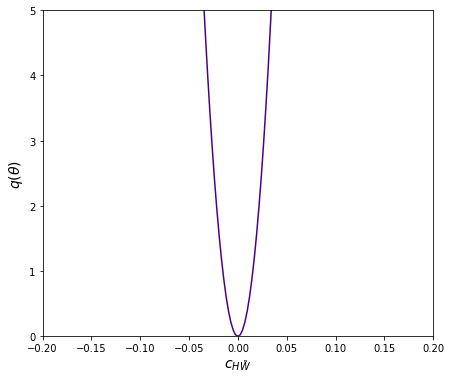

In [7]:
config = {
    'main_dir': '/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes',
    'sample_name': 'wh_signalWithBSM_CP_even',
    'plot_dir': '/lstore/titan/martafsilva/master_thesis/thesis_plots',
    'limits': {
        'lumi': 300,
        'grid_ranges': [[-1.2,1.2]],
        'grid_resolutions': [303]
    }
}


plot_llr_histo(config,"mt_tot_pt_w")
plt.ylim(0,5)
plt.xlim(-0.2,0.2)

Central value (minimum of the LLR): 0.000
Confidence limits at threshold 1.0: [-0.038, 0.036]
Confidence limits at threshold 3.84: [-0.074, 0.070]


(-0.2, 0.2)

<Figure size 504x432 with 0 Axes>

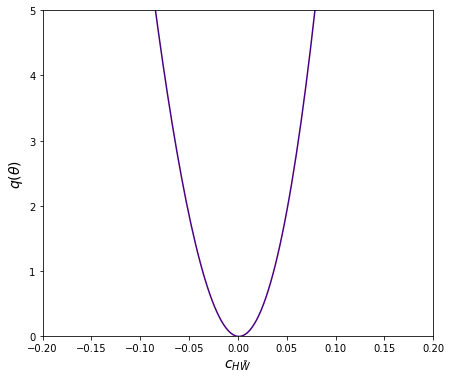

In [8]:
config = {
    'main_dir': '/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes',
    'sample_name': 'wh_signalWithBSMAndBackgrounds_CP_even',
    'plot_dir': '/lstore/titan/martafsilva/master_thesis/thesis_plots',
    'limits': {
        'lumi': 300,
        'grid_ranges': [[-1.2,1.2]],
        'grid_resolutions': [303]
    }
}


plot_llr_histo(config,"ql_cos_deltaPlus_pt_w")
plt.ylim(0,5)
plt.xlim(-0.2,0.2)

# Signal Only vs Signal + Background plots

In [9]:
def calculate_std(load_dir):

    predictions = []

    for i in range(5):
    
      estimator_number = i + 1
      dir =  load_dir + f"/estimator_{i}_data.npz"

      data = np.load(dir)

      parameter_grid = data['parameter_grid']
      llr_kin = data['llr_kin']
      llr_rate = data['llr_rate']
      index_best_point = data['index_best_point']

      rescaled_log_r = llr_kin+llr_rate
      rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    
      predictions.append(rescaled_log_r)

    std_deviation = np.std(predictions, axis=0)

    return std_deviation

In [10]:
plot_dir = '/lstore/titan/martafsilva/master_thesis/thesis_plots'

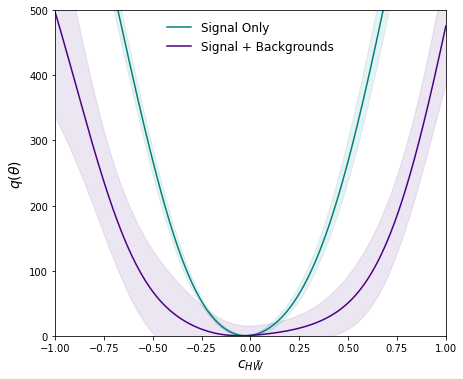

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "signal_vs_background_alices_all_observables_remove_redundant_cos"

# Load data (assuming functions for loading the std are already defined)
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/all_observables_remove_redundant_cos/alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for signal only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for signal + backgrounds
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Signal Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Signal + Backgrounds
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Signal + Backgrounds")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend( frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range
plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )


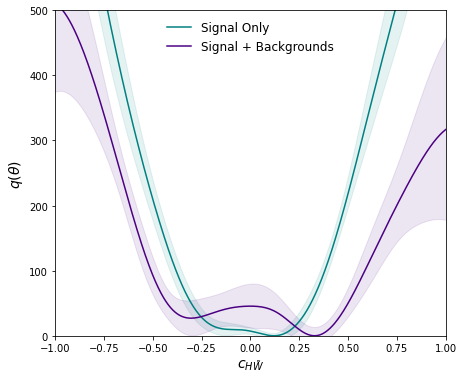

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "signal_vs_background_alice_all_observables_remove_redundant_cos"

# Load data (assuming functions for loading the std are already defined)
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/all_observables_remove_redundant_cos/alices_hidden_[100, 100]_tanh_alpha_0_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for signal only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for signal + backgrounds
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Signal Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Signal + Backgrounds
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Signal + Backgrounds")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend( frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range

plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

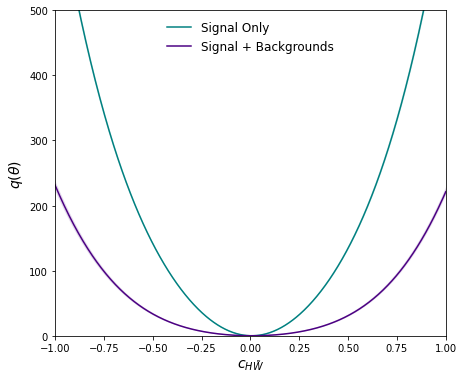

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "signal_vs_background_sally_all_observables_remove_redundant_cos"

# Load data (assuming functions for loading the std are already defined)
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/all_observables_remove_redundant_cos/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/all_observables_remove_redundant_cos/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for signal only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for signal + backgrounds
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Signal Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Signal + Backgrounds
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Signal + Backgrounds")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend( frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range

plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

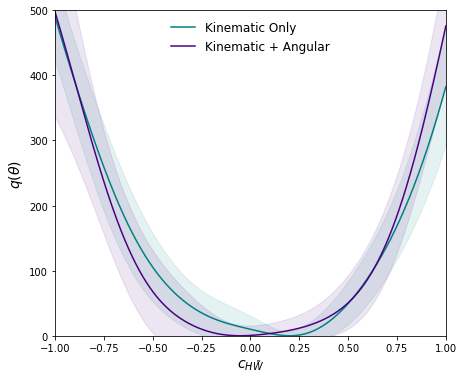

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "angular_vs_kinematic_alices_SB"

# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/all_observables_remove_redundant_cos/alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/kinematic_only/alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Angular observables
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range


plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )


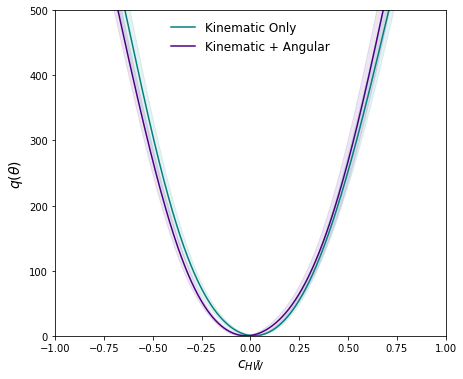

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "angular_vs_kinematic_alices_S"

# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/kinematic_only/alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Angular observables
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range

plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

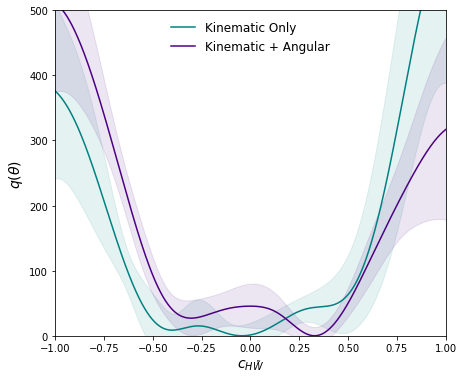

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "angular_vs_kinematic_alice_SB"

# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/all_observables_remove_redundant_cos/alices_hidden_[100, 100]_tanh_alpha_0_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/kinematic_only/alices_hidden_[100, 100]_tanh_alpha_0_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Angular observables
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range


plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

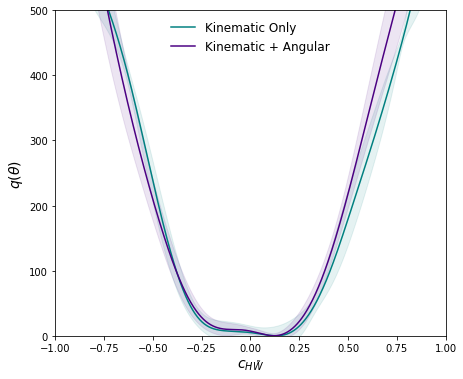

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "angular_vs_kinematic_alice_S"

# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/kinematic_only/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Angular observables
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range


plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

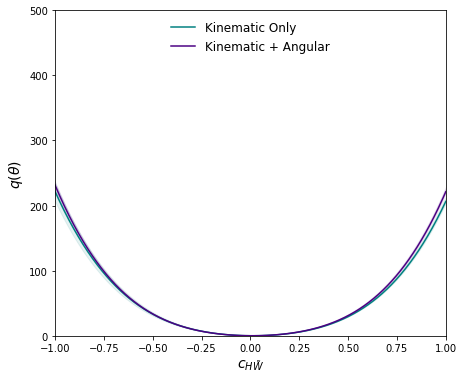

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "angular_vs_kinematic_sally_SB"

# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/all_observables_remove_redundant_cos/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/kinematic_only/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Angular observables
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range


plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

No handles with labels found to put in legend.


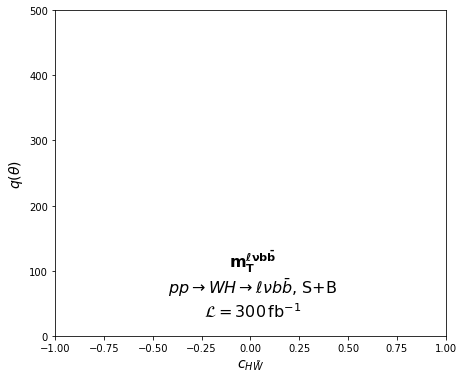

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "angular_vs_kinematic_alice_S"

# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/kinematic_only/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
# plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
# plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# # Angular observables
# plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
# plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range
luminosity_info =  r"$pp \rightarrow W H \rightarrow \ell \nu b \bar{b}$, S+B" + "\n" + r"$\mathcal{L} = 300\, \mathrm{fb}^{-1}$"  
title = r'$\bf{m_T^{\ell \nu b \bar{b}}}$' 

text = title + "\n" + luminosity_info
plt.text(0.01, 30, text,
        fontsize=16,   # Center the text horizontally
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.5),horizontalalignment='center')

plt.savefig(f"{plot_dir}/{fig_name}_text_sally_sb.pdf",dpi=600,bbox_inches='tight' )

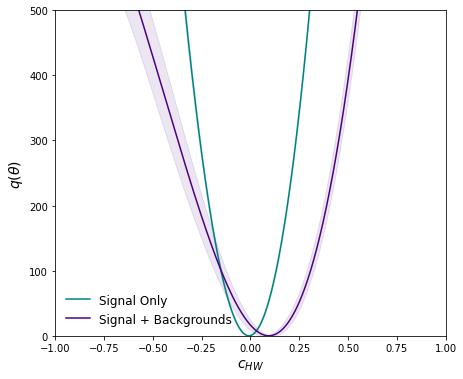

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "signal_vs_background_alices_kinematic_only_cp_even"

# Load data (assuming functions for loading the std are already defined)
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_10e7_samples_CP_even/kinematic_only/alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds_CP_even/range_[-1.0, 1.0]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_5000000_samples_CP_even/kinematic_only/alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128/wh_signalWithBSM_CP_even/range_[-1.0, 1.0]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for signal only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for signal + backgrounds
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Signal Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Signal + Backgrounds
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Signal + Backgrounds")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{HW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend( frameon=False, loc="lower left", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range
plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

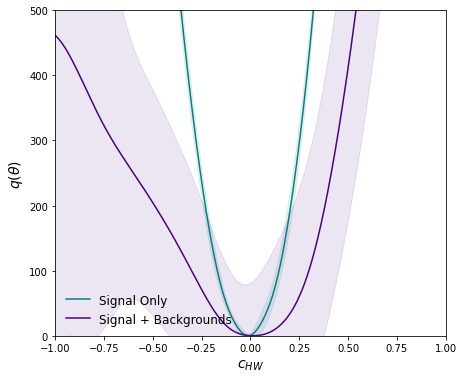

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "signal_vs_background_alice_kinematic_only_cp_even"

# Load data (assuming functions for loading the std are already defined)
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_10e7_samples_CP_even/kinematic_only/alices_hidden_[100, 100]_tanh_alpha_0_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds_CP_even/range_[-1.0, 1.0]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_5000000_samples_CP_even/kinematic_only/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM_CP_even/range_[-1.0, 1.0]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for signal only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for signal + backgrounds
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Signal Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Signal + Backgrounds
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Signal + Backgrounds")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{HW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend( frameon=False, loc="lower left", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range
plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

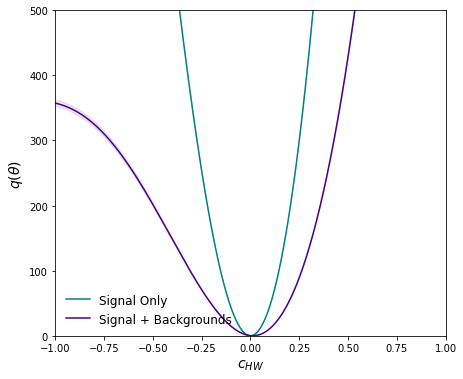

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

fig_name = "signal_vs_background_sally_kinematic_only_cp_even"

# Load data (assuming functions for loading the std are already defined)
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/kinematic_only/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds_CP_even/range_[-1.0, 1.0]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/kinematic_only/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSM_CP_even/range_[-1.0, 1.0]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for signal only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for signal + backgrounds
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Signal Only")
plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# Signal + Backgrounds
plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Signal + Backgrounds")
plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{HW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend( frameon=False, loc="lower left", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range

plt.savefig(f"{plot_dir}/{fig_name}.pdf",dpi=600,bbox_inches='tight' )

# All methods in one plot

No handles with labels found to put in legend.


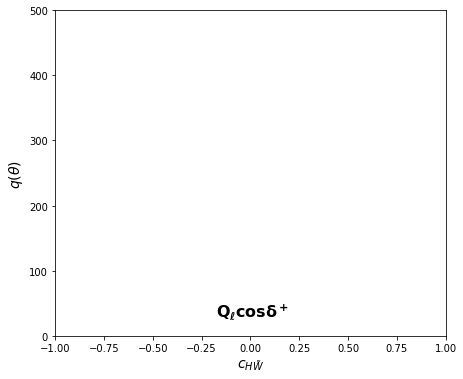

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline



# Load data
load_dir_SB = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"
load_dir_S = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/kinematic_only/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB = np.load(f"{load_dir_SB}/ensemble_data.npz")
data_S = np.load(f"{load_dir_S}/ensemble_data.npz")

parameter_grid_SB = np.squeeze(data_SB['parameter_grid'])
llr_kin_SB = data_SB['llr_kin']
llr_rate_SB = data_SB['llr_rate']
index_best_point_SB = data_SB['index_best_point']

parameter_grid_S = np.squeeze(data_S['parameter_grid'])
llr_kin_S = data_S['llr_kin']
llr_rate_S = data_S['llr_rate']
index_best_point_S = data_S['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB = llr_kin_SB + llr_rate_SB
rescaled_log_r_SB = -2.0 * (rescaled_log_r_SB[:] - rescaled_log_r_SB[index_best_point_SB])
rescaled_log_r_S = llr_kin_S + llr_rate_S
rescaled_log_r_S = -2.0 * (rescaled_log_r_S[:] - rescaled_log_r_S[index_best_point_S])

# Load standard deviations (assuming calculate_std is defined)
std_SB = np.squeeze(calculate_std(load_dir_SB))
std_S = np.squeeze(calculate_std(load_dir_S))

# Spline interpolation for Kinematic Only
spline_S = UnivariateSpline(parameter_grid_S, rescaled_log_r_S, s=0)
spline_S_std_low = UnivariateSpline(parameter_grid_S, rescaled_log_r_S - std_S, s=0)
spline_S_std_high = UnivariateSpline(parameter_grid_S, rescaled_log_r_S + std_S, s=0)

# Spline interpolation for Angular Observables
spline_SB = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB, s=0)
spline_SB_std_low = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB - std_SB, s=0)
spline_SB_std_high = UnivariateSpline(parameter_grid_SB, rescaled_log_r_SB + std_SB, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points = 1001
x_interp = np.linspace(-1.2, 1.2, num_points)

# Plotting
plt.figure(figsize=(7, 6))

# Kinematic only
# plt.plot(x_interp, spline_S(x_interp), lw=1.5, color="teal", label="Kinematic Only")
# plt.fill_between(x_interp, spline_S_std_low(x_interp), spline_S_std_high(x_interp), color="teal", alpha=0.1)

# # Angular observables
# plt.plot(x_interp, spline_SB(x_interp), lw=1.5, color="indigo", label="Kinematic + Angular")
# plt.fill_between(x_interp, spline_SB_std_low(x_interp), spline_SB_std_high(x_interp), color="indigo", alpha=0.1)

# Labels, legend, and limits
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(frameon=False, loc="upper center", fontsize=12)

plt.ylim(-1, 500)
plt.xlim(-1.0, 1.0)  # Adjusted limits to match the new range
luminosity_info =  r"$pp \rightarrow W H \rightarrow \ell \nu b \bar{b}$, K+A, SO" + "\n" + r"$\mathcal{L} = 300\, \mathrm{fb}^{-1}$"  
title = r'$\bf{Q_{\ell}cos\delta^+}$'

#text = title + "\n" + luminosity_info
#text =  luminosity_info
text = title
plt.text(0.01, 30, text,
        fontsize=16,   # Center the text horizontally
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.5),horizontalalignment='center')

fig_name = "KA, SO"
plt.savefig(f"{plot_dir}/qlcos_delta_plus_text.pdf",dpi=600,bbox_inches='tight' )

In [24]:
load_dir_SB_sally = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/all_observables_remove_redundant_cos/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S_sally = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/all_observables_remove_redundant_cos/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB_sally = np.load(f"{load_dir_SB_sally}/ensemble_data.npz")
data_S_sally = np.load(f"{load_dir_S_sally}/ensemble_data.npz")

parameter_grid_SB_sally = np.squeeze(data_SB_sally['parameter_grid'])
llr_kin_SB_sally = data_SB_sally['llr_kin']
llr_rate_SB_sally = data_SB_sally['llr_rate']
index_best_point_SB_sally = data_SB_sally['index_best_point']

parameter_grid_S_sally = np.squeeze(data_S_sally['parameter_grid'])
llr_kin_S_sally = data_S_sally['llr_kin']
llr_rate_S_sally = data_S_sally['llr_rate']
index_best_point_S_sally = data_S_sally['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_sally = llr_kin_SB_sally + llr_rate_SB_sally
rescaled_log_r_SB_sally = -2.0 * (rescaled_log_r_SB_sally[:] - rescaled_log_r_SB_sally[index_best_point_SB_sally])
rescaled_log_r_S_sally = llr_kin_S_sally + llr_rate_S_sally
rescaled_log_r_S_sally = -2.0 * (rescaled_log_r_S_sally[:] - rescaled_log_r_S_sally[index_best_point_S_sally])

# Load standard deviations (assuming calculate_std is defined)
std_SB_sally = np.squeeze(calculate_std(load_dir_SB_sally))
std_S_sally = np.squeeze(calculate_std(load_dir_S_sally))

# Spline interpolation for signal only
spline_S_sally = UnivariateSpline(parameter_grid_S_sally, rescaled_log_r_S_sally, s=0)
spline_S_std_low_sally = UnivariateSpline(parameter_grid_S_sally, rescaled_log_r_S_sally - std_S_sally, s=0)
spline_S_std_high_sally = UnivariateSpline(parameter_grid_S_sally, rescaled_log_r_S_sally + std_S_sally, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_sally = UnivariateSpline(parameter_grid_SB_sally, rescaled_log_r_SB_sally, s=0)
spline_SB_std_low_sally = UnivariateSpline(parameter_grid_SB_sally, rescaled_log_r_SB_sally - std_SB_sally, s=0)
spline_SB_std_high_sally = UnivariateSpline(parameter_grid_SB_sally, rescaled_log_r_SB_sally + std_SB_sally, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_sally = 1001
x_interp_sally = np.linspace(-1.2, 1.2, num_points_sally)



In [25]:
load_dir_SB_alices = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/all_observables_remove_redundant_cos/alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S_alices = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB_alices = np.load(f"{load_dir_SB_alices}/ensemble_data.npz")
data_S_alices = np.load(f"{load_dir_S_alices}/ensemble_data.npz")

parameter_grid_SB_alices = np.squeeze(data_SB_alices['parameter_grid'])
llr_kin_SB_alices = data_SB_alices['llr_kin']
llr_rate_SB_alices = data_SB_alices['llr_rate']
index_best_point_SB_alices = data_SB_alices['index_best_point']

parameter_grid_S_alices = np.squeeze(data_S_alices['parameter_grid'])
llr_kin_S_alices = data_S_alices['llr_kin']
llr_rate_S_alices = data_S_alices['llr_rate']
index_best_point_S_alices = data_S_alices['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_alices = llr_kin_SB_alices + llr_rate_SB_alices
rescaled_log_r_SB_alices = -2.0 * (rescaled_log_r_SB_alices[:] - rescaled_log_r_SB_alices[index_best_point_SB_alices])
rescaled_log_r_S_alices = llr_kin_S_alices + llr_rate_S_alices
rescaled_log_r_S_alices = -2.0 * (rescaled_log_r_S_alices[:] - rescaled_log_r_S_alices[index_best_point_S_alices])

# Load standard deviations (assuming calculate_std is defined)
std_SB_alices = np.squeeze(calculate_std(load_dir_SB_alices))
std_S_alices = np.squeeze(calculate_std(load_dir_S_alices))

# Spline interpolation for signal only
spline_S_alices = UnivariateSpline(parameter_grid_S_alices, rescaled_log_r_S_alices, s=0)
spline_S_std_low_alices = UnivariateSpline(parameter_grid_S_alices, rescaled_log_r_S_alices - std_S_alices, s=0)
spline_S_std_high_alices = UnivariateSpline(parameter_grid_S_alices, rescaled_log_r_S_alices + std_S_alices, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_alices = UnivariateSpline(parameter_grid_SB_alices, rescaled_log_r_SB_alices, s=0)
spline_SB_std_low_alices = UnivariateSpline(parameter_grid_SB_alices, rescaled_log_r_SB_alices - std_SB_alices, s=0)
spline_SB_std_high_alices = UnivariateSpline(parameter_grid_SB_alices, rescaled_log_r_SB_alices + std_SB_alices, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_alices = 1001
x_interp_alices = np.linspace(-1.2, 1.2, num_points_alices)


In [26]:
load_dir_SB_alice = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples/all_observables_remove_redundant_cos/alices_hidden_[100, 100]_tanh_alpha_0_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds/range_[-1.2, 1.2]_resolutions_303"
load_dir_S_alice = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_0.4_10000_thetas_5000000_samples/all_observables_remove_redundant_cos/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM/range_[-1.2, 1.2]_resolutions_303"

data_SB_alice = np.load(f"{load_dir_SB_alice}/ensemble_data.npz")
data_S_alice = np.load(f"{load_dir_S_alice}/ensemble_data.npz")

parameter_grid_SB_alice = np.squeeze(data_SB_alice['parameter_grid'])
llr_kin_SB_alice = data_SB_alice['llr_kin']
llr_rate_SB_alice = data_SB_alice['llr_rate']
index_best_point_SB_alice = data_SB_alice['index_best_point']

parameter_grid_S_alice = np.squeeze(data_S_alice['parameter_grid'])
llr_kin_S_alice = data_S_alice['llr_kin']
llr_rate_S_alice = data_S_alice['llr_rate']
index_best_point_S_alice = data_S_alice['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_alice = llr_kin_SB_alice + llr_rate_SB_alice
rescaled_log_r_SB_alice = -2.0 * (rescaled_log_r_SB_alice[:] - rescaled_log_r_SB_alice[index_best_point_SB_alice])
rescaled_log_r_S_alice = llr_kin_S_alice + llr_rate_S_alice
rescaled_log_r_S_alice = -2.0 * (rescaled_log_r_S_alice[:] - rescaled_log_r_S_alice[index_best_point_S_alice])

# Load standard deviations (assuming calculate_std is defined)
std_SB_alice = np.squeeze(calculate_std(load_dir_SB_alice))
std_S_alice = np.squeeze(calculate_std(load_dir_S_alice))

# Spline interpolation for signal only
spline_S_alice = UnivariateSpline(parameter_grid_S_alice, rescaled_log_r_S_alice, s=0)
spline_S_std_low_alice = UnivariateSpline(parameter_grid_S_alice, rescaled_log_r_S_alice - std_S_alice, s=0)
spline_S_std_high_alice = UnivariateSpline(parameter_grid_S_alice, rescaled_log_r_S_alice + std_S_alice, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_alice = UnivariateSpline(parameter_grid_SB_alice, rescaled_log_r_SB_alice, s=0)
spline_SB_std_low_alice = UnivariateSpline(parameter_grid_SB_alice, rescaled_log_r_SB_alice - std_SB_alice, s=0)
spline_SB_std_high_alice = UnivariateSpline(parameter_grid_SB_alice, rescaled_log_r_SB_alice + std_SB_alice, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_alice = 1001
x_interp_alice = np.linspace(-1.2, 1.2, num_points_alice)


In [27]:
load_dir_SB_hist = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/ql_cos_deltaPlus/wh_signalWithBSMAndBackgrounds/range_[[-1.2, 1.2]]_resolutions_[303]/data_1D.npz"
load_dir_S_hist = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/ql_cos_deltaPlus/wh_signalWithBSM/range_[[-1.2, 1.2]]_resolutions_[303]/data_1D.npz"

data_SB_hist = np.load(f"{load_dir_SB_hist}")
data_S_hist = np.load(f"{load_dir_S_hist}")

parameter_grid_SB_hist = np.squeeze(data_SB_hist['parameter_grid'])
llr_kin_SB_hist = data_SB_hist['llr_kin']
llr_rate_SB_hist = data_SB_hist['llr_rate']
index_best_point_SB_hist = data_SB_hist['index_best_point']

parameter_grid_S_hist = np.squeeze(data_S_hist['parameter_grid'])
llr_kin_S_hist = data_S_hist['llr_kin']
llr_rate_S_hist = data_S_hist['llr_rate']
index_best_point_S_hist = data_S_hist['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_hist = llr_kin_SB_hist + llr_rate_SB_hist
rescaled_log_r_SB_hist = -2.0 * (rescaled_log_r_SB_hist[:] - rescaled_log_r_SB_hist[index_best_point_SB_hist])
rescaled_log_r_S_hist = llr_kin_S_hist + llr_rate_S_hist
rescaled_log_r_S_hist = -2.0 * (rescaled_log_r_S_hist[:] - rescaled_log_r_S_hist[index_best_point_S_hist])


# Spline interpolation for signal only
spline_S_hist = UnivariateSpline(parameter_grid_S_hist, rescaled_log_r_S_hist, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_hist = UnivariateSpline(parameter_grid_SB_hist, rescaled_log_r_SB_hist, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_hist = 1001
x_interp_hist = np.linspace(-1.2, 1.2, num_points_hist)

In [28]:
load_dir_SB_hist_2D = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/ql_cos_deltaPlus_pt_w/wh_signalWithBSMAndBackgrounds/range_[[-1.2, 1.2]]_resolutions_[303]/data_1D_Ricardos_binning.npz"
load_dir_S_hist_2D = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/ql_cos_deltaPlus_pt_w/wh_signalWithBSM/range_[[-1.2, 1.2]]_resolutions_[303]/data_1D_Ricardos_binning.npz"

data_SB_hist_2D = np.load(f"{load_dir_SB_hist_2D}")
data_S_hist_2D = np.load(f"{load_dir_S_hist_2D}")

parameter_grid_SB_hist_2D = np.squeeze(data_SB_hist_2D['parameter_grid'])
llr_kin_SB_hist_2D = data_SB_hist_2D['llr_kin']
llr_rate_SB_hist_2D = data_SB_hist_2D['llr_rate']
index_best_point_SB_hist_2D = data_SB_hist_2D['index_best_point']

parameter_grid_S_hist_2D = np.squeeze(data_S_hist_2D['parameter_grid'])
llr_kin_S_hist_2D = data_S_hist_2D['llr_kin']
llr_rate_S_hist_2D = data_S_hist_2D['llr_rate']
index_best_point_S_hist_2D = data_S_hist_2D['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_hist_2D = llr_kin_SB_hist_2D + llr_rate_SB_hist_2D
rescaled_log_r_SB_hist_2D = -2.0 * (rescaled_log_r_SB_hist_2D[:] - rescaled_log_r_SB_hist_2D[index_best_point_SB_hist_2D])
rescaled_log_r_S_hist_2D = llr_kin_S_hist_2D + llr_rate_S_hist_2D
rescaled_log_r_S_hist_2D = -2.0 * (rescaled_log_r_S_hist_2D[:] - rescaled_log_r_S_hist_2D[index_best_point_S_hist_2D])


# Spline interpolation for signal only
spline_S_hist_2D = UnivariateSpline(parameter_grid_S_hist_2D, rescaled_log_r_S_hist_2D, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_hist_2D = UnivariateSpline(parameter_grid_SB_hist_2D, rescaled_log_r_SB_hist_2D, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_hist = 1001
x_interp_hist_2D = np.linspace(-1.2, 1.2, num_points_hist)

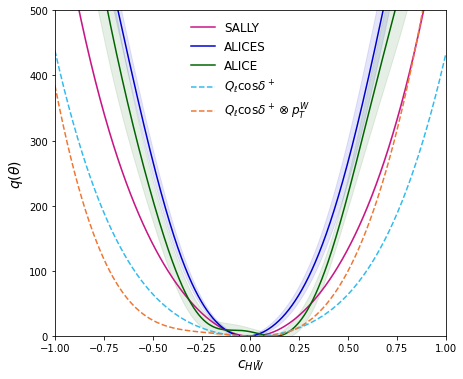

In [29]:
# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp_sally, spline_S_sally(x_interp_sally), lw=1.5, color="mediumvioletred", label="SALLY")
plt.fill_between(x_interp_sally, spline_S_std_low_sally(x_interp_sally), spline_S_std_high_sally(x_interp_sally), color="mediumvioletred", alpha=0.1)

plt.plot(x_interp_alices, spline_S_alices(x_interp_alices), lw=1.5, color="mediumblue", label="ALICES")
plt.fill_between(x_interp_alices, spline_S_std_low_alices(x_interp_alices), spline_S_std_high_alices(x_interp_alices), color="mediumblue", alpha=0.1)

plt.plot(x_interp_alice, spline_S_alice(x_interp_alice), lw=1.5, color="darkgreen", label="ALICE")
plt.fill_between(x_interp_alice, spline_S_std_low_alice(x_interp_alice), spline_S_std_high_alice(x_interp_alice), color="darkgreen", alpha=0.1)

plt.plot(x_interp_hist, spline_S_hist(x_interp_hist), lw=1.5, ls='--',color="#33BBEE", label=r'$Q_{\ell}  \cos  \delta^+$')

plt.plot(x_interp_hist_2D, spline_S_hist_2D(x_interp_hist_2D), lw=1.5, ls='--',color="#EE7733", label=r'$Q_{\ell}  \cos  \delta^+ \otimes p_T^W$')

plt.xlim(-1.0,1.0)
plt.ylim(0,500)
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(fontsize=12,frameon=False)

plt.savefig("/lstore/titan/martafsilva/master_thesis/thesis_plots/1D_CP_odd_signal_only_all_methods.pdf",dpi=600,bbox_inches='tight')

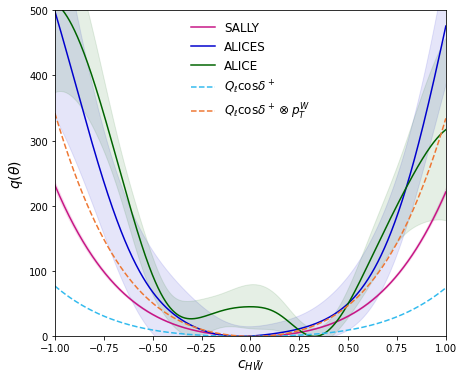

In [30]:
# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp_sally, spline_SB_sally(x_interp_sally), lw=1.5, color="mediumvioletred", label="SALLY")
plt.fill_between(x_interp_sally, spline_SB_std_low_sally(x_interp_sally), spline_SB_std_high_sally(x_interp_sally), color="mediumvioletred", alpha=0.1)

plt.plot(x_interp_alices, spline_SB_alices(x_interp_alices), lw=1.5, color="mediumblue", label="ALICES")
plt.fill_between(x_interp_alices, spline_SB_std_low_alices(x_interp_alices), spline_SB_std_high_alices(x_interp_alices), color="mediumblue", alpha=0.1)

plt.plot(x_interp_alice, spline_SB_alice(x_interp_alice), lw=1.5, color="darkgreen", label="ALICE")
plt.fill_between(x_interp_alice, spline_SB_std_low_alice(x_interp_alice), spline_SB_std_high_alice(x_interp_alice), color="darkgreen", alpha=0.1)

plt.plot(x_interp_hist, spline_SB_hist(x_interp_hist), lw=1.5, ls = '--',color="#33BBEE", label=r'$Q_{\ell}  \cos  \delta^+$')
plt.plot(x_interp_hist_2D, spline_SB_hist_2D(x_interp_hist_2D), ls = '--',lw=1.5, color="#EE7733", label=r'$Q_{\ell}  \cos  \delta^+\otimes p_T^W$')

plt.xlim(-1.0,1.0)
plt.ylim(0,500)
plt.xlabel(r"$c_{H\tildeW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(fontsize=12,frameon=False)

plt.savefig("/lstore/titan/martafsilva/master_thesis/thesis_plots/1D_CP_odd_signal_and_backgrounds_all_methods.pdf",dpi=600,bbox_inches='tight')

In [31]:
load_dir_SB_sally = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/kinematic_only/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds_CP_even/range_[-1.0, 1.0]_resolutions_303"
load_dir_S_sally = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/sally/kinematic_only/sally_hidden_[50]_relu_epochs_50_bs_128/wh_signalWithBSM_CP_even/range_[-1.0, 1.0]_resolutions_303"

data_SB_sally = np.load(f"{load_dir_SB_sally}/ensemble_data.npz")
data_S_sally = np.load(f"{load_dir_S_sally}/ensemble_data.npz")

parameter_grid_SB_sally = np.squeeze(data_SB_sally['parameter_grid'])
llr_kin_SB_sally = data_SB_sally['llr_kin']
llr_rate_SB_sally = data_SB_sally['llr_rate']
index_best_point_SB_sally = data_SB_sally['index_best_point']

parameter_grid_S_sally = np.squeeze(data_S_sally['parameter_grid'])
llr_kin_S_sally = data_S_sally['llr_kin']
llr_rate_S_sally = data_S_sally['llr_rate']
index_best_point_S_sally = data_S_sally['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_sally = llr_kin_SB_sally + llr_rate_SB_sally
rescaled_log_r_SB_sally = -2.0 * (rescaled_log_r_SB_sally[:] - rescaled_log_r_SB_sally[index_best_point_SB_sally])
rescaled_log_r_S_sally = llr_kin_S_sally + llr_rate_S_sally
rescaled_log_r_S_sally = -2.0 * (rescaled_log_r_S_sally[:] - rescaled_log_r_S_sally[index_best_point_S_sally])

# Load standard deviations (assuming calculate_std is defined)
std_SB_sally = np.squeeze(calculate_std(load_dir_SB_sally))
std_S_sally = np.squeeze(calculate_std(load_dir_S_sally))

# Spline interpolation for signal only
spline_S_sally = UnivariateSpline(parameter_grid_S_sally, rescaled_log_r_S_sally, s=0)
spline_S_std_low_sally = UnivariateSpline(parameter_grid_S_sally, rescaled_log_r_S_sally - std_S_sally, s=0)
spline_S_std_high_sally = UnivariateSpline(parameter_grid_S_sally, rescaled_log_r_S_sally + std_S_sally, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_sally = UnivariateSpline(parameter_grid_SB_sally, rescaled_log_r_SB_sally, s=0)
spline_SB_std_low_sally = UnivariateSpline(parameter_grid_SB_sally, rescaled_log_r_SB_sally - std_SB_sally, s=0)
spline_SB_std_high_sally = UnivariateSpline(parameter_grid_SB_sally, rescaled_log_r_SB_sally + std_SB_sally, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_sally = 1001
x_interp_sally = np.linspace(-1.2, 1.2, num_points_sally)


In [32]:
load_dir_SB_alices = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_10e7_samples_CP_even/kinematic_only/alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds_CP_even/range_[-1.0, 1.0]_resolutions_303"
load_dir_S_alices = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_5000000_samples_CP_even/kinematic_only/alices_hidden_[50]_relu_alpha_5_epochs_100_bs_128/wh_signalWithBSM_CP_even/range_[-1.0, 1.0]_resolutions_303"

data_SB_alices = np.load(f"{load_dir_SB_alices}/ensemble_data.npz")
data_S_alices = np.load(f"{load_dir_S_alices}/ensemble_data.npz")

parameter_grid_SB_alices = np.squeeze(data_SB_alices['parameter_grid'])
llr_kin_SB_alices = data_SB_alices['llr_kin']
llr_rate_SB_alices = data_SB_alices['llr_rate']
index_best_point_SB_alices = data_SB_alices['index_best_point']

parameter_grid_S_alices = np.squeeze(data_S_alices['parameter_grid'])
llr_kin_S_alices = data_S_alices['llr_kin']
llr_rate_S_alices = data_S_alices['llr_rate']
index_best_point_S_alices = data_S_alices['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_alices = llr_kin_SB_alices + llr_rate_SB_alices
rescaled_log_r_SB_alices = -2.0 * (rescaled_log_r_SB_alices[:] - rescaled_log_r_SB_alices[index_best_point_SB_alices])
rescaled_log_r_S_alices = llr_kin_S_alices + llr_rate_S_alices
rescaled_log_r_S_alices = -2.0 * (rescaled_log_r_S_alices[:] - rescaled_log_r_S_alices[index_best_point_S_alices])

# Load standard deviations (assuming calculate_std is defined)
std_SB_alices = np.squeeze(calculate_std(load_dir_SB_alices))
std_S_alices = np.squeeze(calculate_std(load_dir_S_alices))

# Spline interpolation for signal only
spline_S_alices = UnivariateSpline(parameter_grid_S_alices, rescaled_log_r_S_alices, s=0)
spline_S_std_low_alices = UnivariateSpline(parameter_grid_S_alices, rescaled_log_r_S_alices - std_S_alices, s=0)
spline_S_std_high_alices = UnivariateSpline(parameter_grid_S_alices, rescaled_log_r_S_alices + std_S_alices, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_alices = UnivariateSpline(parameter_grid_SB_alices, rescaled_log_r_SB_alices, s=0)
spline_SB_std_low_alices = UnivariateSpline(parameter_grid_SB_alices, rescaled_log_r_SB_alices - std_SB_alices, s=0)
spline_SB_std_high_alices = UnivariateSpline(parameter_grid_SB_alices, rescaled_log_r_SB_alices + std_SB_alices, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_alices = 1001
x_interp_alices = np.linspace(-1.2, 1.2, num_points_alices)


In [33]:
load_dir_SB_alice = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_10e7_samples_CP_even/kinematic_only/alices_hidden_[100, 100]_tanh_alpha_0_epochs_50_bs_128/wh_signalWithBSMAndBackgrounds_CP_even/range_[-1.0, 1.0]_resolutions_303"
load_dir_S_alice = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits/alices_gaussian_prior_0_03_10000_thetas_5000000_samples_CP_even/kinematic_only/alices_hidden_[50]_relu_alpha_0_epochs_100_bs_128/wh_signalWithBSM_CP_even/range_[-1.0, 1.0]_resolutions_303"

data_SB_alice = np.load(f"{load_dir_SB_alice}/ensemble_data.npz")
data_S_alice = np.load(f"{load_dir_S_alice}/ensemble_data.npz")

parameter_grid_SB_alice = np.squeeze(data_SB_alice['parameter_grid'])
llr_kin_SB_alice = data_SB_alice['llr_kin']
llr_rate_SB_alice = data_SB_alice['llr_rate']
index_best_point_SB_alice = data_SB_alice['index_best_point']

parameter_grid_S_alice = np.squeeze(data_S_alice['parameter_grid'])
llr_kin_S_alice = data_S_alice['llr_kin']
llr_rate_S_alice = data_S_alice['llr_rate']
index_best_point_S_alice = data_S_alice['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_alice = llr_kin_SB_alice + llr_rate_SB_alice
rescaled_log_r_SB_alice = -2.0 * (rescaled_log_r_SB_alice[:] - rescaled_log_r_SB_alice[index_best_point_SB_alice])
rescaled_log_r_S_alice = llr_kin_S_alice + llr_rate_S_alice
rescaled_log_r_S_alice = -2.0 * (rescaled_log_r_S_alice[:] - rescaled_log_r_S_alice[index_best_point_S_alice])

# Load standard deviations (assuming calculate_std is defined)
std_SB_alice = np.squeeze(calculate_std(load_dir_SB_alice))
std_S_alice = np.squeeze(calculate_std(load_dir_S_alice))

# Spline interpolation for signal only
spline_S_alice = UnivariateSpline(parameter_grid_S_alice, rescaled_log_r_S_alice, s=0)
spline_S_std_low_alice = UnivariateSpline(parameter_grid_S_alice, rescaled_log_r_S_alice - std_S_alice, s=0)
spline_S_std_high_alice = UnivariateSpline(parameter_grid_S_alice, rescaled_log_r_S_alice + std_S_alice, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_alice = UnivariateSpline(parameter_grid_SB_alice, rescaled_log_r_SB_alice, s=0)
spline_SB_std_low_alice = UnivariateSpline(parameter_grid_SB_alice, rescaled_log_r_SB_alice - std_SB_alice, s=0)
spline_SB_std_high_alice = UnivariateSpline(parameter_grid_SB_alice, rescaled_log_r_SB_alice + std_SB_alice, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_alice = 1001
x_interp_alice = np.linspace(-1.2, 1.2, num_points_alice)

In [34]:
load_dir_SB_hist = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/mt_tot/wh_signalWithBSMAndBackgrounds_CP_even/range_[[-1.0, 1.0]]_resolutions_[303]/data_1D_Ricardos_binning.npz"
load_dir_S_hist = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/mt_tot/wh_signalWithBSM_CP_even/range_[[-1.0, 1.0]]_resolutions_[303]/data_1D_Ricardos_binning.npz"

data_SB_hist = np.load(f"{load_dir_SB_hist}")
data_S_hist = np.load(f"{load_dir_S_hist}")

parameter_grid_SB_hist = np.squeeze(data_SB_hist['parameter_grid'])
llr_kin_SB_hist = data_SB_hist['llr_kin']
llr_rate_SB_hist = data_SB_hist['llr_rate']
index_best_point_SB_hist = data_SB_hist['index_best_point']

parameter_grid_S_hist = np.squeeze(data_S_hist['parameter_grid'])
llr_kin_S_hist = data_S_hist['llr_kin']
llr_rate_S_hist = data_S_hist['llr_rate']
index_best_point_S_hist = data_S_hist['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_hist = llr_kin_SB_hist + llr_rate_SB_hist
rescaled_log_r_SB_hist = -2.0 * (rescaled_log_r_SB_hist[:] - rescaled_log_r_SB_hist[index_best_point_SB_hist])
rescaled_log_r_S_hist = llr_kin_S_hist + llr_rate_S_hist
rescaled_log_r_S_hist = -2.0 * (rescaled_log_r_S_hist[:] - rescaled_log_r_S_hist[index_best_point_S_hist])


# Spline interpolation for signal only
spline_S_hist = UnivariateSpline(parameter_grid_S_hist, rescaled_log_r_S_hist, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_hist = UnivariateSpline(parameter_grid_SB_hist, rescaled_log_r_SB_hist, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_hist = 1001
x_interp_hist = np.linspace(-1.2, 1.2, num_points_hist)

In [35]:
load_dir_SB_hist_2D = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/mt_tot_pt_w/wh_signalWithBSMAndBackgrounds_CP_even/range_[[-1.2, 1.2]]_resolutions_[303]/data_1D_Ricardos_binning.npz"
load_dir_S_hist_2D = "/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes/llr_fits_hist/mt_tot_pt_w/wh_signalWithBSM_CP_even/range_[[-1.2, 1.2]]_resolutions_[303]/data_1D_Ricardos_binning.npz"

data_SB_hist_2D = np.load(f"{load_dir_SB_hist_2D}")
data_S_hist_2D = np.load(f"{load_dir_S_hist_2D}")

parameter_grid_SB_hist_2D = np.squeeze(data_SB_hist_2D['parameter_grid'])
llr_kin_SB_hist_2D = data_SB_hist_2D['llr_kin']
llr_rate_SB_hist_2D = data_SB_hist_2D['llr_rate']
index_best_point_SB_hist_2D = data_SB_hist_2D['index_best_point']

parameter_grid_S_hist_2D = np.squeeze(data_S_hist_2D['parameter_grid'])
llr_kin_S_hist_2D = data_S_hist_2D['llr_kin']
llr_rate_S_hist_2D = data_S_hist_2D['llr_rate']
index_best_point_S_hist_2D = data_S_hist_2D['index_best_point']

# Calculate rescaled log-likelihood ratios
rescaled_log_r_SB_hist_2D = llr_kin_SB_hist_2D + llr_rate_SB_hist_2D
rescaled_log_r_SB_hist_2D = -2.0 * (rescaled_log_r_SB_hist_2D[:] - rescaled_log_r_SB_hist_2D[index_best_point_SB_hist_2D])
rescaled_log_r_S_hist_2D = llr_kin_S_hist_2D + llr_rate_S_hist_2D
rescaled_log_r_S_hist_2D = -2.0 * (rescaled_log_r_S_hist_2D[:] - rescaled_log_r_S_hist_2D[index_best_point_S_hist_2D])


# Spline interpolation for signal only
spline_S_hist_2D = UnivariateSpline(parameter_grid_S_hist_2D, rescaled_log_r_S_hist_2D, s=0)

# Spline interpolation for signal + backgrounds
spline_SB_hist_2D = UnivariateSpline(parameter_grid_SB_hist_2D, rescaled_log_r_SB_hist_2D, s=0)

# Create a finer grid with 1001 points for smooth interpolation
num_points_hist = 1001
x_interp_hist_2D = np.linspace(-1.2, 1.2, num_points_hist)

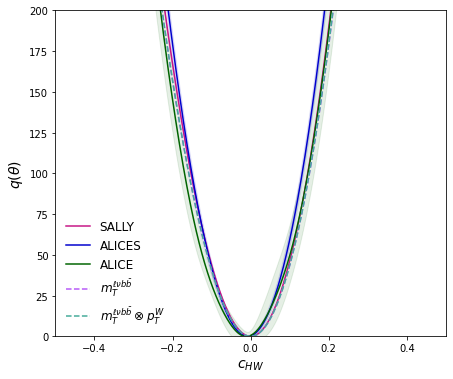

In [36]:
# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp_sally, spline_S_sally(x_interp_sally), lw=1.5, color="mediumvioletred", label="SALLY")
plt.fill_between(x_interp_sally, spline_S_std_low_sally(x_interp_sally), spline_S_std_high_sally(x_interp_sally), color="mediumvioletred", alpha=0.1)

plt.plot(x_interp_alices, spline_S_alices(x_interp_alices), lw=1.5, color="mediumblue", label="ALICES")
plt.fill_between(x_interp_alices, spline_S_std_low_alices(x_interp_alices), spline_S_std_high_alices(x_interp_alices), color="mediumblue", alpha=0.1)

plt.plot(x_interp_alice, spline_S_alice(x_interp_alice), lw=1.5, color="darkgreen", label="ALICE")
plt.fill_between(x_interp_alice, spline_S_std_low_alice(x_interp_alice), spline_S_std_high_alice(x_interp_alice), color="darkgreen", alpha=0.1)

plt.plot(x_interp_hist, spline_S_hist(x_interp_hist), lw=1.5,ls='--', color="#B759F8", label=r'$m_T^{\ell \nu b \bar{b}} $')
plt.plot(x_interp_hist_2D, spline_S_hist_2D(x_interp_hist_2D),ls='--', lw=1.5, color="#44AA99", label=r'$m_T^{\ell \nu b \bar{b}} \otimes p_T^W$')

plt.xlim(-0.5,0.5)
plt.ylim(0,200)
plt.xlabel(r"$c_{HW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(fontsize=12,frameon=False)

plt.savefig("/lstore/titan/martafsilva/master_thesis/thesis_plots/1D_CP_even_signal_only_all_methods.pdf",dpi=600,bbox_inches='tight')

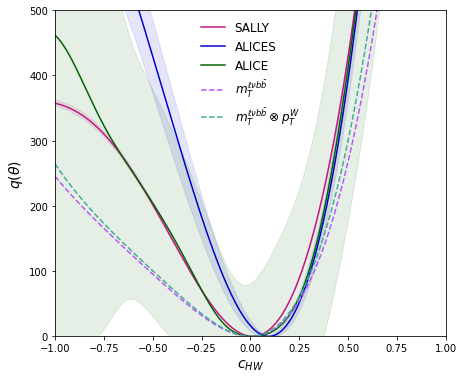

In [37]:
# Plotting
plt.figure(figsize=(7, 6))

# Signal only
plt.plot(x_interp_sally, spline_SB_sally(x_interp_sally), lw=1.5, color="mediumvioletred", label="SALLY")
plt.fill_between(x_interp_sally, spline_SB_std_low_sally(x_interp_sally), spline_SB_std_high_sally(x_interp_sally), color="mediumvioletred", alpha=0.1)

plt.plot(x_interp_alices, spline_SB_alices(x_interp_alices), lw=1.5, color="mediumblue", label="ALICES")
plt.fill_between(x_interp_alices, spline_SB_std_low_alices(x_interp_alices), spline_SB_std_high_alices(x_interp_alices), color="mediumblue", alpha=0.1)

plt.plot(x_interp_alice, spline_SB_alice(x_interp_alice), lw=1.5, color="darkgreen", label="ALICE")
plt.fill_between(x_interp_alice, spline_SB_std_low_alice(x_interp_alice), spline_SB_std_high_alice(x_interp_alice), color="darkgreen", alpha=0.1)

plt.plot(x_interp_hist, spline_SB_hist(x_interp_hist), lw=1.5, ls='--',color="#B759F8", label=r'$m_T^{\ell \nu b \bar{b}} $')
plt.plot(x_interp_hist_2D, spline_SB_hist_2D(x_interp_hist_2D), ls='--',lw=1.5, color="#44AA99", label=r'$m_T^{\ell \nu b \bar{b}} \otimes p_T^W$')

plt.xlim(-1.0,1.0)
plt.ylim(0,500)
plt.xlabel(r"$c_{HW}$", size=14)
plt.ylabel(r"$q(\theta)$", size=14)
plt.legend(fontsize=12,frameon=False)

plt.savefig("/lstore/titan/martafsilva/master_thesis/thesis_plots/1D_CP_even_signal_and_backgrounds_all_methods.pdf",dpi=600,bbox_inches='tight')

# Summary Plots

In [ ]:
from scipy.stats import chi2
def calculate_std(config):
    
    load_dir = f"{config['main_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/{config['sample_name']}/range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"
    

    predictions = []
    p_values= []

    for i in range(5):
    
      estimator_number = i + 1
      dir =  load_dir + f"/estimator_{i}_data.npz"

      data = np.load(dir)

      parameter_grid = data['parameter_grid']
      llr_kin = data['llr_kin']
      llr_rate = data['llr_rate']
      index_best_point = data['index_best_point']
      
      rescaled_log_r = llr_kin+llr_rate
      rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    
      predictions.append(rescaled_log_r)

    std_deviation = np.std(predictions, axis=0)
    mean_predictions = np.mean(predictions, axis=0)
    p_values_mean = np.mean(p_values,axis=0)

    p_values_llr = chi2.sf(x=mean_predictions, df=1)
    print(p_values_llr)

    return std_deviation, mean_predictions

In [ ]:
config = {
    'main_dir': '/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes',
    'sample_name': 'wh_signalWithBSMAndBackgrounds',
    'plot_dir': '/lstore/titan/martafsilva/master_thesis/thesis_plots',
    'limits': {
        'mode': 'ml',
        'observables': 'kinematic_only',
        'prior': 'alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples',
        'model': 'alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128',
        'method': 'alices',
        'lumi': 300,
        'grid_ranges': [-1.2,1.2],
        'grid_resolutions': 303
    }
}
calculate_std(config)

In [ ]:

def plot_llr_ensemble(config):
    
    plt.figure(figsize=(7,6))
    
    load_dir = f"{config['main_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/{config['sample_name']}/range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"

    fig_name = f"llr_fit_ensemble_{config['sample_name']}_range_{config['limits']['grid_ranges']}_resolutions_{config['limits']['grid_resolutions']}"

    os.makedirs(f"{config['plot_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/",exist_ok=True)
    save_dir = f"{config['plot_dir']}/llr_fits/{config['limits']['prior']}/{config['limits']['observables']}/{config['limits']['model']}/"
    
    data = np.load(f"{load_dir}/ensemble_data.npz")

    parameter_grid = data['parameter_grid']
    llr_kin = data['llr_kin']
    llr_rate = data['llr_rate']
    index_best_point = data['index_best_point']
    p_values = data['p_values']
    print(p_values)

    # Define interpolation points
    num_points = 1001
    x_interp = np.linspace(-1.2, 1.2, num_points)  # Adjusted range and density


    if config['limits']['method'] == 'sally':
      title = r'$\bf{SALLY}$' 
      color = 'mediumvioletred'

    if config['limits']['method'] == 'alices':
      title = r'$\bf{ALICES}$' + r'$\ (\alpha = 5, n_{\theta_0} = 10000)$'
      color = 'mediumblue'

    if config['limits']['method'] == 'alice':
      title = title = r'$\bf{ALICE}$' + r'$\ (\alpha = 0, n_{\theta_0} = 1000)$'
      color = 'darkgreen'
        


    plt.figure(figsize=(7, 6))

    rescaled_log_r = llr_kin+llr_rate
    rescaled_log_r = -2.0*(rescaled_log_r[:] - rescaled_log_r[index_best_point])    

    std = calculate_std(config)
    std = np.squeeze(std)
    parameter_grid = np.squeeze(parameter_grid)
    
    # Perform quadratic spline interpolation
    spline = UnivariateSpline(parameter_grid, rescaled_log_r, k=2, s=0)
    rescaled_log_r_interp = spline(x_interp)
    
    # Perform quadratic spline interpolation for the standard deviation
    spline_std = UnivariateSpline(parameter_grid, std, k=2, s=0)
    std_interp = spline_std(x_interp)
    
    min_index = np.argmin(rescaled_log_r_interp)
    central_value = x_interp[min_index]
    std_at_min = std_interp[min_index]  # Standard deviation at the minimum
    
    # Print the results
    print(f"Central value (minimum of the LLR): {central_value:.3f}")
    print(f"Standard deviation at the central value: {std_at_min:.3f}")
    

    lw = 1.5
    # Fill the region between the interpolated log-likelihood ± interpolated standard deviation
    plt.fill_between(x_interp, rescaled_log_r_interp - std_interp, rescaled_log_r_interp + std_interp, color=color, alpha=0.1)
    

    plt.plot(x_interp, rescaled_log_r_interp ,linewidth=lw, color=color)    
    
    # # Add horizontal lines and labels for CL
    # plt.axhline(y=1.0, color='dimgray', linestyle='-.', linewidth=1.2)
    # plt.axhline(y=3.84, color='dimgray', linestyle='--', linewidth=1.2)

    # Adding text labels directly on the lines
    # plt.text(-0.095, 1.0, '68% CL', color='dimgray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
    # plt.text(-0.095, 3.84, '95% CL', color='dimgray', verticalalignment='bottom', horizontalalignment='left', fontsize=11)
    

    plt.xlabel(r"$c_{H\tilde{W}}$", size=14)
    plt.ylabel(r"$q(\theta)$", size=14) 
    plt.ylim(-0.02,500)
    plt.xlim(-1.2,1.2)
    luminosity_info =  r"$u \bar{d} \rightarrow W^+ H \rightarrow \mu^+ \nu_{\mu} b \bar{b}$, KO" + "\n" + r"$\mathcal{L} = 300\, \mathrm{fb}^{-1}$"  
    
    #text = title + "\n" + luminosity_info
    # plt.text(0.001, 8, text,
    #      fontsize=12,   # Center the text horizontally
    #      bbox=dict(facecolor='white', edgecolor='none', alpha=0.5),horizontalalignment='center')
    
    #plt.savefig(f"{save_dir}/{fig_name}.pdf", dpi=600,bbox_inches='tight')
    
     # Find confidence limits
    find_confidence_limits(x_interp, rescaled_log_r_interp, 1.0)
    find_confidence_limits(x_interp, rescaled_log_r_interp, 3.84)

In [ ]:
config = {
    'main_dir': '/lstore/titan/martafsilva/master_thesis/master_thesis_output/detector_level_pythia_and_delphes',
    'sample_name': 'wh_signalWithBSMAndBackgrounds',
    'plot_dir': '/lstore/titan/martafsilva/master_thesis/thesis_plots',
    'limits': {
        'mode': 'ml',
        'observables': 'kinematic_only',
        'prior': 'alices_gaussian_prior_0_0.4_10000_thetas_10e7_samples',
        'model': 'alices_hidden_[100, 100]_tanh_alpha_5_epochs_50_bs_128',
        'method': 'alices',
        'lumi': 300,
        'grid_ranges': [-1.2,1.2],
        'grid_resolutions': 303
    }
}
plot_llr_ensemble(config)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = ["$c_{Hq}^{(3)}$", "$c_{Hu}$", "$c_{Hq}^{(3)}$", "$c_{Hu}$"]

parameter_means = [0.1, -0.2, 0.1, -0.2]  # Best-fit values
ci_68 = [0.3, 0.2, 0.3, 0.2]  # 68% confidence intervals (half-width)
ci_95 = [0.5, 0.4, 0.5, 0.4]   # 95% confidence intervals (half-width)

# Creating the plot
fig, ax = plt.subplots(figsize=(6, 8))

# Loop over each parameter and plot the error bars for the two parameterizations
for i, param in enumerate(parameters):
    # Plot for linear parameterisation (solid lines for 68% CL)
    if i == 0:  # Add legend only once
        ax.errorbar(parameter_means[i], i + 0.1, xerr=ci_68[i], fmt='o', color='blue', ecolor='blue', label='Linear 68% CL', linestyle='-')
        ax.errorbar(parameter_means[i], i + 0.1, xerr=ci_95[i], fmt='o', color='black', ecolor='blue', linestyle='--', label='Linear 95% CL')
        ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_68[i], fmt='o', color='green', label='Lin + Quad 68% CL', linestyle='-')
        ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_95[i], fmt='o', color='black', linestyle='--', label='Lin + Quad 95% CL')
    else:  # No legend for subsequent iterations
        ax.errorbar(parameter_means[i], i + 0.1, xerr=ci_68[i], fmt='o', color='blue', ecolor='blue', linestyle='-')
        ax.errorbar(parameter_means[i], i + 0.1, xerr=ci_95[i], fmt='o', color='black', ecolor='blue', linestyle='--')
        ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_68[i], fmt='o', color='green', linestyle='-')
        ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_95[i], fmt='o', color='black', linestyle='--')

# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters])

# Labels and styling
ax.set_xlabel("Parameter value")
ax.set_xlim([-3, 3])  # Same range as in the image
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Vertical line at 0
plt.title("Confidence Intervals for Parameters", loc='left')

# Legend
# plt.legend()

# Grid and plot display
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = ["$c_{Hq}^{(3)}$", "$c_{Hu}$", "$c_{Hq}^{(3)}$", "$c_{Hu}$"]

parameter_means = [0.1, -0.2, 0.1, -0.2]  # Best-fit values
ci_68 = [0.3, 0.2, 0.3, 0.2]  # 68% confidence intervals (half-width)
ci_95 = [0.5, 0.4, 0.5, 0.4]   # 95% confidence intervals (half-width)

# Creating the plot
fig, ax = plt.subplots(figsize=(5, 6))

# Loop over each parameter and plot the error bars for the two parameterizations
for i, param in enumerate(parameters):
    # Plot for linear parameterisation
    eb1_95 = ax.errorbar(parameter_means[i], i + 0.1, xerr=ci_95[i], fmt='o', color='black', ecolor ='blue', label='Linear 95% CL' if i == 0 else "")
    eb1_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb1 = ax.errorbar(parameter_means[i], i + 0.1, xerr=ci_68[i], fmt='o', color='black', label='Linear 68% CL' if i == 0 else "")
    
    # Plot for linear + quadratic parameterisation
    eb2 = ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_68[i], fmt='o', color='green', label='Lin + Quad 68% CL' if i == 0 else "")
    eb2_95 = ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_95[i], fmt='o', color='black', label='Lin + Quad 95% CL' if i == 0 else "")
    eb2_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb2 = ax.errorbar(parameter_means[i], i - 0.1, xerr=ci_68[i], fmt='o', color='green', label='Lin + Quad 68% CL' if i == 0 else "")
   
# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters], size = 14)

# Labels and styling
ax.set_xlabel("Parameter value", size = 14)
ax.set_xlim([-1, 1])  # Same range as in the image
ax.axvline(x=0, color='black', linestyle='--', linewidth=1)  # Vertical line at 0

# Legend
# plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = ["$c_{Hq}^{(3)}$", "$c_{Hu}$", "$c_{Hq}^{(3)}$", "$c_{Hu}$"]

parameter_means = [0.1, -0.2, 0.1, -0.2]  # Best-fit values

# Asymmetric 68% confidence intervals: (lower, upper)
ci_68_lower = [0.2, 0.15, 0.2, 0.15]  # Lower bound for 68% CL
ci_68_upper = [0.4, 0.25, 0.4, 0.25]  # Upper bound for 68% CL

# Asymmetric 95% confidence intervals: (lower, upper)
ci_95_lower = [0.4, 0.35, 0.4, 0.35]  # Lower bound for 95% CL
ci_95_upper = [0.6, 0.45, 0.6, 0.45]  # Upper bound for 95% CL

# Creating the plot
fig, ax = plt.subplots(figsize=(5, 5))

# Loop over each parameter and plot the error bars for the three cases
for i, param in enumerate(parameters):
    # First line: Linear parameterization (68% and 95% CL)
    eb1_95 = ax.errorbar(parameter_means[i], i + 0.1, 
                         xerr=[[ci_95_lower[i]], [ci_95_upper[i]]], 
                         fmt='o', color='black', ecolor='blue', label='Linear 95% CL' if i == 0 else "")
    eb1_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb1_68 = ax.errorbar(parameter_means[i], i + 0.1, 
                         xerr=[[ci_68_lower[i]], [ci_68_upper[i]]], 
                         fmt='o', color='black', label='Linear 68% CL' if i == 0 else "")

    # Second line: Linear + quadratic parameterization (68% and 95% CL)
    eb2_95 = ax.errorbar(parameter_means[i], i, 
                         xerr=[[ci_95_lower[i]], [ci_95_upper[i]]], 
                         fmt='o', color='black', ecolor='green', label='Lin + Quad 95% CL' if i == 0 else "")
    eb2_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb2_68 = ax.errorbar(parameter_means[i], i, 
                         xerr=[[ci_68_lower[i]], [ci_68_upper[i]]], 
                         fmt='o', color='green', label='Lin + Quad 68% CL' if i == 0 else "")

    # Third line: Custom (e.g., resolved vs boosted)
    eb3_95 = ax.errorbar(parameter_means[i], i - 0.1, 
                         xerr=[[ci_95_lower[i]], [ci_95_upper[i]]], 
                         fmt='o', color='black', ecolor='orange', label='Custom 95% CL' if i == 0 else "")
    eb3_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb3_68 = ax.errorbar(parameter_means[i], i - 0.1, 
                         xerr=[[ci_68_lower[i]], [ci_68_upper[i]]], 
                         fmt='o', color='orange', label='Custom 68% CL' if i == 0 else "")

# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters], size=14)

# Draw horizontal line to separate groups
ax.hlines(y=1.5, xmin=-1, xmax=1, color='black', linestyle='-', linewidth=1)

# Labels and styling
ax.set_xlabel("Parameter value", size=14)
ax.set_xlim([-1, 1])  # Same range as in the image
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Vertical line at 0
ax.set_ylim(-0.3, len(parameters)-0.3 )  # Adjust y-limits to add space at the bottom

# Optional: add a legend
# plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



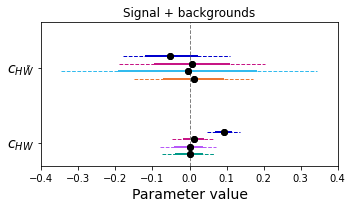

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = [ r"$c_{HW}$",r"$c_{H\tildeW}$"]

parameter_means_alices = [0.094, -0.053]  # Best-fit values
parameter_means_sally = [0.012, 0.007]
parameter_means_histo= [0.000, -0.005]
parameter_means_histo_2D= [0.000, 0.012]


# Asymmetric 68% confidence intervals: (lower, upper)
ci_68_lower_alices = [0.070, -0.120]  # Lower bound for 68% CL
ci_68_upper_alices = [0.115, 0.022]  # Upper bound for 68% CL
ci_68_lower_sally = [-0.017, -0.096]  # Lower bound for 68% CL
ci_68_upper_sally = [0.038, 0.110]  # Upper bound for 68% CL
ci_68_lower_histo = [-0.041, -0.194]  # Lower bound for 68% CL
ci_68_upper_histo = [0.036, 0.182]  # Upper bound for 68% CL
ci_68_lower_histo_2D = [-0.038, -0.072]  # Lower bound for 68% CL
ci_68_upper_histo_2D = [0.036, 0.094]  # Upper bound for 68% CL

# Asymmetric 95% confidence intervals: (lower, upper)
ci_95_lower_alices = [0.048, -0.180]  # Lower bound for 95% CL
ci_95_upper_alices = [0.137, 0.110]  # Upper bound for 95% CL
ci_95_lower_sally = [-0.046, -0.190]  # Lower bound for 95% CL
ci_95_upper_sally = [0.062, 0.204]  # Upper bound for 95% CL
ci_95_lower_histo = [-0.079, -0.348]  # Lower bound for 95% CL
ci_95_upper_histo = [0.072, 0.343]  # Upper bound for 95% CL
ci_95_lower_histo_2D = [-0.074, -0.151]  # Lower bound for 95% CL
ci_95_upper_histo_2D = [0.070, 0.170]  # Upper bound for 95% CL

# Creating the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Loop over each parameter and plot the error bars for the three cases
colors = [ "#B759F8","#33BBEE"]
colors2= [ "#009988","#EE7733"]
for i, param in enumerate(parameters):
    # First line: Linear parameterization (68% and 95% CL)
    eb1_95 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_95_lower_alices[i]], 
                               [ci_95_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=1)
    eb1_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb1_68 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_68_lower_alices[i]], 
                               [ci_68_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=2)

    # Second line: Linear + quadratic parameterization (68% and 95% CL)
    eb2_95 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_95_lower_sally[i]], 
                               [ci_95_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=1)
    eb2_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb2_68 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_68_lower_sally[i]], 
                               [ci_68_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=2)

    # Third line: Custom (e.g., resolved vs boosted)
    eb3_95 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_95_lower_histo[i]], 
                               [ci_95_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=1)
    eb3_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb3_68 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_68_lower_histo[i]], 
                               [ci_68_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=2)

    eb4_95 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_95_lower_histo_2D[i]], 
                               [ci_95_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=1)
    eb4_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb4_68 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_68_lower_histo_2D[i]], 
                               [ci_68_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=2)

# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters], size=14)

# Draw horizontal line to separate groups

# Labels and styling
ax.set_xlabel("Parameter value", size=14)
ax.set_xlim([-0.4, 0.4])  # Same range as in the image
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Vertical line at 0
ax.set_ylim(-0.3, len(parameters)-0.4)  # Adjust y-limits to add space at the bottom

# Optional: add a legend
# plt.legend()
plt.title("Signal + backgrounds")
# Adjust layout
plt.tight_layout()

plt.savefig("summary_plot_1D_signal_and_backgrounds_title.pdf", dpi=600,bbox_inches='tight')

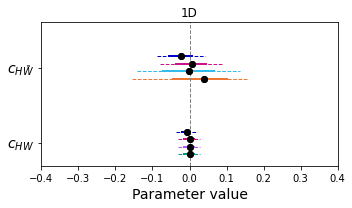

In [91]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = [ r"$c_{HW}$",r"$c_{H\tildeW}$"]

parameter_means_alices = [-0.007, -0.024]  # Best-fit values
parameter_means_sally = [0.000, 0.007]
parameter_means_histo= [0.000, -0.002]
parameter_means_histo_2D= [0.000, 0.038]


# Asymmetric 68% confidence intervals: (lower, upper)
ci_68_lower_alices = [-0.024,-0.058]  # Lower bound for 68% CL
ci_68_upper_alices = [0.005,0.010]  # Upper bound for 68% CL
ci_68_lower_sally = [-0.017, -0.038]  # Lower bound for 68% CL
ci_68_upper_sally = [0.014, 0.048]  # Upper bound for 68% CL
ci_68_lower_histo = [-0.017, -0.074]  # Lower bound for 68% CL
ci_68_upper_histo = [0.014, 0.070]  # Upper bound for 68% CL
ci_68_lower_histo_2D = [-0.017, -0.046]  # Lower bound for 95% CL
ci_68_upper_histo_2D = [0.014, 0.103]  # Upper bound for 95% CL

# Asymmetric 95% confidence intervals: (lower, upper)
ci_95_lower_alices = [-0.036, -0.089]  # Lower bound for 95% CL
ci_95_upper_alices = [0.019, 0.043]  # Upper bound for 95% CL
ci_95_lower_sally = [-0.031, -0.079]  # Lower bound for 95% CL
ci_95_upper_sally = [0.029, 0.089]  # Upper bound for 95% CL
ci_95_lower_histo = [-0.031, -0.142]  # Lower bound for 95% CL
ci_95_upper_histo = [0.029, 0.137]  # Upper bound for 95% CL
ci_95_lower_histo_2D = [-0.031, -0.156]  # Lower bound for 95% CL
ci_95_upper_histo_2D = [0.029, 0.158]  # Upper bound for 95% CL

# Creating the plot
fig, ax = plt.subplots(figsize=(5, 3))

colors = [ "#B759F8","#33BBEE"]
colors2= [ "#009988","#EE7733"]
for i, param in enumerate(parameters):
    # First line: Linear parameterization (68% and 95% CL)
    # First line: Linear parameterization (68% and 95% CL)
    eb1_95 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_95_lower_alices[i]], 
                               [ci_95_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=1)
    eb1_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb1_68 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_68_lower_alices[i]], 
                               [ci_68_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=2)

    # Second line: Linear + quadratic parameterization (68% and 95% CL)
    eb2_95 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_95_lower_sally[i]], 
                               [ci_95_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=1)
    eb2_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb2_68 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_68_lower_sally[i]], 
                               [ci_68_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=2)

    # Third line: Custom (e.g., resolved vs boosted)
    eb3_95 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_95_lower_histo[i]], 
                               [ci_95_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=1)
    eb3_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb3_68 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_68_lower_histo[i]], 
                               [ci_68_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=2)

    eb4_95 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_95_lower_histo_2D[i]], 
                               [ci_95_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=1)
    eb4_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb4_68 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_68_lower_histo_2D[i]], 
                               [ci_68_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=2)

# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters], size=14)

# Draw horizontal line to separate groups

# Labels and styling
ax.set_xlabel("Parameter value", size=14)
ax.set_xlim([-0.4, 0.4])  # Same range as in the image
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Vertical line at 0
ax.set_ylim(-0.3, len(parameters)-0.4)  # Adjust y-limits to add space at the bottom

# Optional: add a legend
# plt.legend()
plt.scatter(-1,1,color = 'black', label = "Best-fit, 1D",)
#plt.legend(frameon=False, fontsize=12)
# Adjust layout
plt.title("1D")
plt.tight_layout()


plt.savefig("summary_plot_1D_signal_only_title_1D.pdf", dpi=600,bbox_inches='tight')


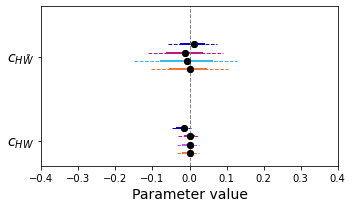

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = [ r"$c_{HW}$",r"$c_{H\tildeW}$"]

parameter_means_alices = [-0.016, 0.011]  # Best-fit values
parameter_means_sally = [0.000, -0.011]
parameter_means_histo= [0.000, -0.008]
parameter_means_histo_2D= [0.000, 0.000]


# Asymmetric 68% confidence intervals: (lower, upper)
ci_68_lower_alices = [-0.037,-0.026]  # Lower bound for 68% CL
ci_68_upper_alices = [-0.005,0.042]  # Upper bound for 68% CL
ci_68_lower_sally = [-0.016, -0.064]  # Lower bound for 68% CL
ci_68_upper_sally = [0.016, 0.037]  # Upper bound for 68% CL
ci_68_lower_histo = [-0.020, -0.079]  # Lower bound for 68% CL
ci_68_upper_histo = [0.013, 0.064]  # Upper bound for 68% CL
ci_68_lower_histo_2D = [-0.020, -0.056]  # Lower bound for 68% CL
ci_68_upper_histo_2D = [0.013, 0.048]  # Upper bound for 68% CL

# Asymmetric 95% confidence intervals: (lower, upper)
ci_95_lower_alices = [-0.048, -0.058]  # Lower bound for 95% CL
ci_95_upper_alices = [0.005, 0.074]  # Upper bound for 95% CL
ci_95_lower_sally = [-0.032, -0.111]  # Lower bound for 95% CL
ci_95_upper_sally = [0.026, 0.090]  # Upper bound for 95% CL
ci_95_lower_histo = [-0.033, -0.151]  # Lower bound for 95% CL
ci_95_upper_histo = [0.026, 0.127]  # Upper bound for 95% CL
ci_95_lower_histo_2D = [-0.033, -0.103]  # Lower bound for 95% CL
ci_95_upper_histo_2D = [0.026, 0.103]  # Upper bound for 95% CL

# Creating the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Loop over each parameter and plot the error bars for the three cases
colors = [ "#B759F8","#33BBEE"]
colors2= [ "#EE7733","#EE7733"]
for i, param in enumerate(parameters):
    # First line: Linear parameterization (68% and 95% CL)
    eb1_95 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_95_lower_alices[i]], 
                               [ci_95_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=1)
    eb1_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb1_68 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_68_lower_alices[i]], 
                               [ci_68_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=2)

    # Second line: Linear + quadratic parameterization (68% and 95% CL)
    eb2_95 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_95_lower_sally[i]], 
                               [ci_95_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=1)
    eb2_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb2_68 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_68_lower_sally[i]], 
                               [ci_68_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=2)

    # Third line: Custom (e.g., resolved vs boosted)
    eb3_95 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_95_lower_histo[i]], 
                               [ci_95_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=1)
    eb3_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb3_68 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_68_lower_histo[i]], 
                               [ci_68_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=2)

    eb4_95 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_95_lower_histo_2D[i]], 
                               [ci_95_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=1)
    eb4_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb4_68 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_68_lower_histo_2D[i]], 
                               [ci_68_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=2)

# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters], size=14)

# Draw horizontal line to separate groups

# Labels and styling
ax.set_xlabel("Parameter value", size=14)
ax.set_xlim([-0.4, 0.4])  # Same range as in the image
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Vertical line at 0
ax.set_ylim(-0.3, len(parameters)-0.4)  # Adjust y-limits to add space at the bottom

# Optional: add a legend
# plt.legend()
plt.scatter(-1,1,color = 'black', label = "Best-fit, 2D",)
#plt.legend(frameon=False, fontsize=12)
# Adjust layout
plt.tight_layout()

plt.savefig("summary_plot_2D_signal_only.pdf", dpi=600,bbox_inches='tight')



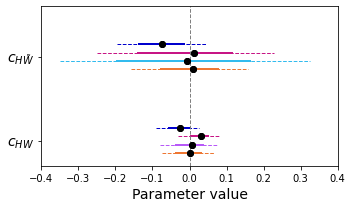

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the plot
parameters = [ r"$c_{HW}$",r"$c_{H\tildeW}$"]

parameter_means_alices = [-0.026, -0.074]  # Best-fit values
parameter_means_sally = [0.032, 0.011]
parameter_means_histo= [0.007, -0.008]
parameter_means_histo_2D= [0.000, 0.008]

# Asymmetric 68% confidence intervals: (lower, upper)
ci_68_lower_alices = [-0.058,-0.138]  # Lower bound for 68% CL
ci_68_upper_alices = [0.000,-0.011]  # Upper bound for 68% CL
ci_68_lower_sally = [-0.000, -0.143]  # Lower bound for 68% CL
ci_68_upper_sally = [0.053, 0.117]  # Upper bound for 68% CL
ci_68_lower_histo = [-0.040, -0.199]  # Lower bound for 68% CL
ci_68_upper_histo = [0.040, 0.167]  # Upper bound for 68% CL
ci_68_lower_histo_2D = [-0.040, -0.079]  # Lower bound for 68% CL
ci_68_upper_histo_2D = [0.033, 0.079]  # Upper bound for 68% CL

# Asymmetric 95% confidence intervals: (lower, upper)
ci_95_lower_alices = [-0.090, -0.196]  # Lower bound for 95% CL
ci_95_upper_alices = [0.026, 0.048]  # Upper bound for 95% CL
ci_95_lower_sally = [-0.032, -0.249]  # Lower bound for 95% CL
ci_95_upper_sally = [0.079, 0.228]  # Upper bound for 95% CL
ci_95_lower_histo = [-0.079, -0.350]  # Lower bound for 95% CL
ci_95_upper_histo = [0.073, 0.326]  # Upper bound for 95% CL
ci_95_lower_histo_2D = [-0.073, -0.159]  # Lower bound for 95% CL
ci_95_upper_histo_2D = [0.066, 0.159]  # Upper bound for 95% CL

# Creating the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Loop over each parameter and plot the error bars for the three cases
colors = [ "#B759F8","#33BBEE"]
colors2= [ "#EE7733","#EE7733"]
for i, param in enumerate(parameters):
    # First line: Linear parameterization (68% and 95% CL)
    eb1_95 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_95_lower_alices[i]], 
                               [ci_95_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=1)
    eb1_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb1_68 = ax.errorbar(parameter_means_alices[i], i + 0.15, 
                         xerr=[[parameter_means_alices[i] - ci_68_lower_alices[i]], 
                               [ci_68_upper_alices[i] - parameter_means_alices[i]]], 
                         fmt='o', color='black', ecolor='mediumblue', elinewidth=2)

    # Second line: Linear + quadratic parameterization (68% and 95% CL)
    eb2_95 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_95_lower_sally[i]], 
                               [ci_95_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=1)
    eb2_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb2_68 = ax.errorbar(parameter_means_sally[i], i+0.05, 
                         xerr=[[parameter_means_sally[i] - ci_68_lower_sally[i]], 
                               [ci_68_upper_sally[i] - parameter_means_sally[i]]], 
                         fmt='o', color='black', ecolor='mediumvioletred', elinewidth=2)

    # Third line: Custom (e.g., resolved vs boosted)
    eb3_95 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_95_lower_histo[i]], 
                               [ci_95_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=1)
    eb3_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb3_68 = ax.errorbar(parameter_means_histo[i], i-0.05 , 
                         xerr=[[parameter_means_histo[i] - ci_68_lower_histo[i]], 
                               [ci_68_upper_histo[i] - parameter_means_histo[i]]], 
                         fmt='o', color='black', ecolor=colors[i], elinewidth=2)

    eb4_95 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_95_lower_histo_2D[i]], 
                               [ci_95_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=1)
    eb4_95[-1][0].set_linestyle('--')  # Set dashed linestyle for 95% CL
    eb4_68 = ax.errorbar(parameter_means_histo_2D[i], i - 0.15, 
                         xerr=[[parameter_means_histo_2D[i] - ci_68_lower_histo_2D[i]], 
                               [ci_68_upper_histo_2D[i] - parameter_means_histo_2D[i]]], 
                         fmt='o', color='black', ecolor=colors2[i], elinewidth=2)

# Set the y-ticks to be the parameter names
ax.set_yticks(np.arange(len(parameters)))  # Fix the y-tick positions to match the actual number of points
ax.set_yticklabels([f"{param} " for param in parameters], size=14)

# Draw horizontal line to separate groups

# Labels and styling
ax.set_xlabel("Parameter value", size=14)
ax.set_xlim([-0.4, 0.4])  # Same range as in the image
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)  # Vertical line at 0
ax.set_ylim(-0.3, len(parameters)-0.4)  # Adjust y-limits to add space at the bottom

# Optional: add a legend
# plt.legend()
plt.scatter(-1,1,color = 'black', label = "Best-fit, 2D",)
#plt.legend(frameon=False, fontsize=12)
# Adjust layout
plt.tight_layout()

plt.savefig("summary_plot_2D_signal_and_backgrounds.pdf", dpi=600,bbox_inches='tight')
